In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import warnings
warnings.filterwarnings("ignore")

In [28]:
data_17 = pd.read_csv("../data/modis_2017_India.csv")
data_18 = pd.read_csv("../data/modis_2018_India.csv")
data_19 = pd.read_csv("../data/modis_2019_India.csv")
data_20 = pd.read_csv("../data/modis_2020_India.csv")
data_21 = pd.read_csv("../data/modis_2021_India.csv")
data_22 = pd.read_csv("../data/modis_2022_India.csv")

In [29]:
!pip install -q category_encoders

In [30]:
# Merge all dataframes into one dataframe
df = pd.concat([data_17,data_18,data_19,data_20,data_21,data_22])

In [31]:
print(df['satellite'].value_counts())
print(df['daynight'].value_counts())
print(df['type'].value_counts())

satellite
Aqua     355846
Terra    162124
Name: count, dtype: int64
daynight
D    460816
N     57154
Name: count, dtype: int64
type
0    490993
2     26853
3       120
1         4
Name: count, dtype: int64


In [32]:
df = df.query('type != 1 and type != 3')
df.reset_index(drop=True, inplace=True)

In [33]:
df.loc[df['type'] == 2, 'type'] = 1

In [34]:
df["type"].value_counts()

type
0    490993
1     26853
Name: count, dtype: int64

In [35]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['satellite'])
df = encoder.fit_transform(df)
encoder = ce.BinaryEncoder(cols=['daynight'])
df = encoder.fit_transform(df)

In [36]:
df=df.drop(['satellite_1','daynight_1'], axis=1)
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['acq_date'] = df['acq_date'].apply(lambda x: x.timestamp())

In [37]:
df['acq_time'] = df['acq_time']//100 
df.head()
    

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite_0,instrument,confidence,version,bright_t31,frp,daynight_0,type
0,31.4814,75.7365,301.5,1.4,1.2,1.483229e+09,5,0,MODIS,48,6.2,291.1,5.4,0,0
1,28.7628,79.5194,311.3,1.0,1.0,1.483229e+09,5,0,MODIS,71,6.2,292.8,8.6,0,0
2,28.0761,79.8547,304.2,1.0,1.0,1.483229e+09,5,0,MODIS,58,6.2,290.6,5.0,0,0
3,28.5888,78.7448,305.0,1.0,1.0,1.483229e+09,5,0,MODIS,60,6.2,293.5,4.3,0,0
4,29.4661,77.1339,303.3,1.1,1.1,1.483229e+09,5,0,MODIS,56,6.2,291.6,5.6,0,0


In [38]:
df.drop(["instrument"],axis=1,inplace=True)

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
target=['type']

feature_cols = [x for x in df.columns if x not in target]

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(df[feature_cols], df[target]))

# Create the data sets
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, target]
X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, target]

<Axes: >

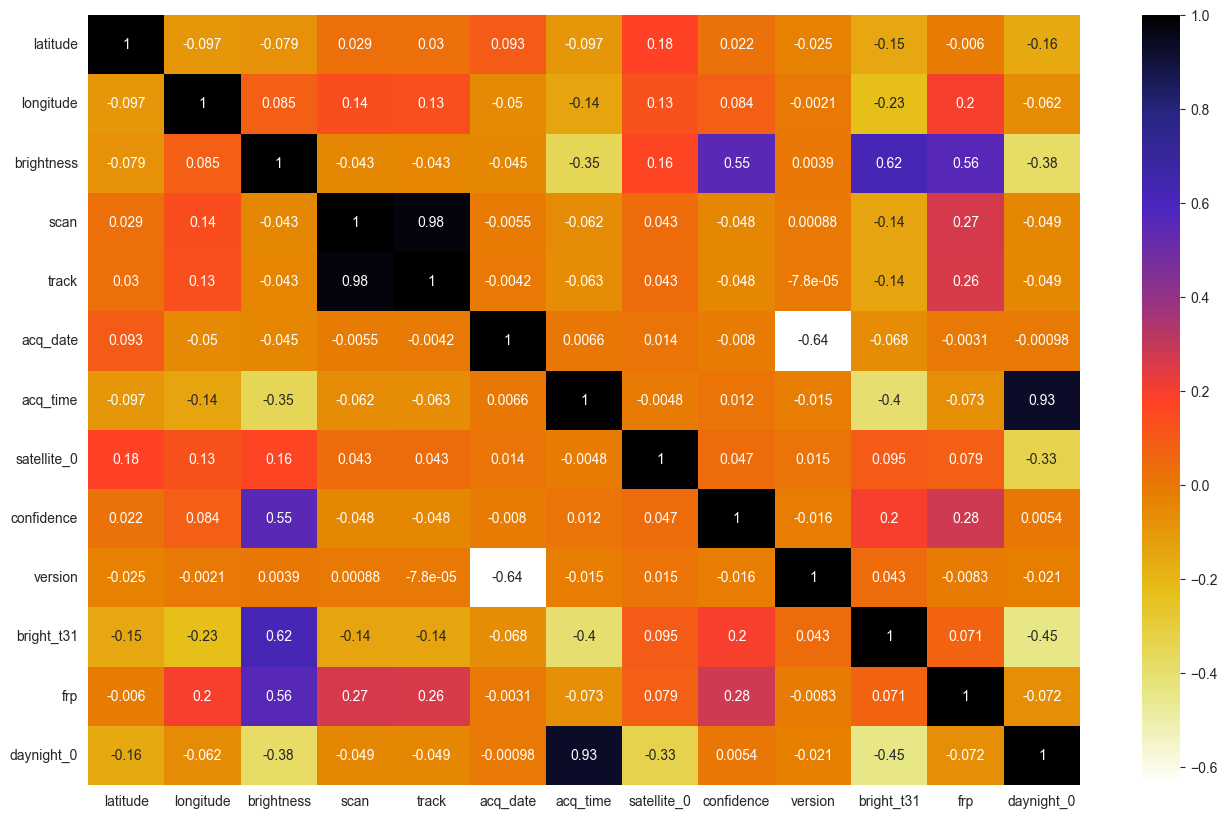

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
cor=X_train.corr(numeric_only=True)
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)

In [41]:
def correlation(dataset, threshold):
     col_corr = set() # Set of all the names of correlated columns
     corr_matrix = dataset.corr(numeric_only=True)
     for i in range(len(corr_matrix.columns)):
         for j in range(i):
             if (corr_matrix.iloc[i,j])>threshold: # we are interested in absolute coeff value
                 colname= corr_matrix.columns[i] # getting the name of column
                 col_corr.add(colname) 
     return col_corr


In [42]:
features= correlation(X_train,0.9)
print(set(features))

{'daynight_0', 'track'}


In [43]:
X_train=X_train.drop(['track','daynight_0'],axis=1)

In [44]:
X_test=X_test.drop(['track','daynight_0'],axis=1)

In [23]:
X_train.columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'acq_date', 'acq_time',
       'satellite_0', 'confidence', 'version', 'bright_t31', 'frp'],
      dtype='object')

In [19]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'max_depth': [3, 4, 5, 6, 7],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
#     'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
#     'tree_method': ['gpu_hist']  # Use GPU accelerated algorithm
# }

# # Initialize XGBoost classifier
# xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',predictor='gpu_predictor')

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_parameters = grid_search.best_params_

# # Fit the model with the best parameters
# xgb_best = xgb.XGBClassifier(**best_parameters)
# xgb_best.fit(X_train, y_train)

# # Predict the test set results
# y_pred = xgb_best.predict(X_test)

# # Print the results
# print("Best parameters for XGBoost: ", best_parameters)
# print(classification_report(y_test, y_pred))
# print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))

In [45]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [24]:
from keras.models import load_model
from pathlib import Path

path = Path("best_model.h5")
model = load_model(path)

2024-02-24 07:02:59.351524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
type(y_train)

pandas.core.frame.DataFrame

In [48]:
model.fit(X_train, y_train_categorical, epochs=2, batch_size=64)

Epoch 1/2
 806/6474 [==>...........................] - ETA: 1:01 - loss: 0.0933 - accuracy: 0.9733

KeyboardInterrupt: 

In [20]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import StandardScaler

# # Scale the data
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# # Convert the labels to categorical
# y_train_categorical = to_categorical(y_train)
# y_test_categorical = to_categorical(y_test)

# # Define the model
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(y_train.iloc[:, 0].unique()), activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train_categorical, epochs=10, batch_size=64)

# # Evaluate the model
# _, accuracy = model.evaluate(X_test, y_test_categorical)
# print(f'Accuracy: {accuracy * 100}%')

In [21]:
X_train.shape

(414276, 11)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from kerastuner.tuners import RandomSearch
import tqdm


# Scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(len(y_train.iloc[:, 0].unique()), activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

# Define the distribution strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=2,
        executions_per_trial=3,
        directory='/kaggle/working/runs',
        project_name='helloworld')

tuner.search_space_summary()

tuner.search(X_train, y_train_categorical,
             epochs=10,
             validation_data=(X_test, y_test_categorical))

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
_, accuracy = best_model.evaluate(X_test, y_test_categorical)
print(f'Accuracy: {accuracy * 100}%')

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
20                |20                |num_layers
256               |256               |units_0
96                |96                |units_1
0.001             |0.001             |learning_rate

Epoch 1/10
12947/12947 [==============================] - 106s 8ms/step - loss: 0.1029 - accuracy: 0.9695 - val_loss: 0.0890 - val_accuracy: 0.9741
Epoch 2/10
12947/12947 [==============================] - 98s 

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from kerastuner.tuners import RandomSearch

# Scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(len(y_train.iloc[:, 0].unique()), activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

tuner.search_space_summary()

tuner.search(X_train, y_train_categorical,
             epochs=3,
             validation_data=(X_test, y_test_categorical))

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
_, accuracy = best_model.evaluate(X_test, y_test_categorical)
print(f'Accuracy: {accuracy * 100}%')

Trial 2 Complete [00h 13m 28s]
val_accuracy: 0.9763444860776266

Best val_accuracy So Far: 0.9763444860776266
Total elapsed time: 00h 26m 00s
Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
num_layers: 20
units_0: 352
units_1: 32
learning_rate: 0.001
units_2: 96
units_3: 384
units_4: 384
units_5: 192
units_6: 96
units_7: 96
units_8: 160
units_9: 288
units_10: 32
units_11: 512
units_12: 64
units_13: 64
units_14: 416
units_15: 64
units_16: 320
units_17: 32
units_18: 32
units_19: 32
Score: 0.9763444860776266

Trial 0 summary
Hyperparameters:
num_layers: 17
units_0: 192
units_1: 448
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16: 32
Score: 0.94814133644104
3237/3237 [==============================] - 9s 3ms/step - loss: 0.0810 - accurac

In [20]:
best_model.save("/kaggle/working/best_model.h5")

In [23]:
best_model.save("/kaggle/working/best_model_final",save_format="tf")

In [ ]:
best_model.summary()

In [24]:
X_train.shape

(414276, 11)

In [25]:
X_train.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [27]:
out = best_model.predict(X_test)

3237/3237 [==============================] - 6s 2ms/step


In [28]:
out

array([[9.7243249e-01, 2.7567534e-02],
       [9.9625850e-01, 3.7414781e-03],
       [8.8282377e-02, 9.1171759e-01],
       ...,
       [9.7020078e-01, 2.9799221e-02],
       [9.9663299e-01, 3.3670238e-03],
       [9.9950051e-01, 4.9951632e-04]], dtype=float32)